In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

### Model Hyperparameters

In [2]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 10
        self.batch_size = 64
        self.learning_rate = 0.001
        self.dropout_rate = 0.25
        self.num_classes = 10
        self.momentum = 0.9
        self.random_seed = 42

### Model

In [ ]:
# Model-1
# CNN Model Definition
class TinyCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 8x28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x14x14
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 8x14x14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 16x7x7
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [8]:
# model-2
# CNN Model Definition
class TinyCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(TinyCNN, self).__init__()
        
        # First Convolutional Block - reduced filters from 16 to 8
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Second Convolutional Block - reduced filters from 32 to 16
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fully Connected Layers - reduced hidden layer from 128 to 64
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(16 * 7 * 7, 32),  # Changed from 32*7*7, 128 to 16*7*7, 64
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 10)  # Changed from 128, 10 to 64, 10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Train Function

In [4]:
def train_model(params):
    # Set random seed for reproducibility
    torch.manual_seed(params.random_seed)
    
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TinyCNN(params.dropout_rate).to(device)
    
    # Print model summary
    print("\nModel Summary:")
    summary(model, input_size=(1, 28, 28))
    print("\nStarting Training...\n")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(params.num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{params.num_epochs}')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{running_loss/len(progress_bar):.3f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)
        
        # Modified metrics printing
        print(f'Epoch {epoch+1}/{params.num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
    
    return model, train_losses, train_accuracies, test_accuracies


In [5]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

In [6]:
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:40<00:00, 247kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 79.4kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 250kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.44MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Linear-3                   [-1, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
----------------------------------------------------------------

Starting Training...



Epoch 1/10: 100%|██████████| 938/938 [00:36<00:00, 25.64it/s, loss=0.192, acc=94.29%]


Epoch 1/10 - Loss: 0.1917, Train Acc: 94.29%, Test Acc: 98.04%


Epoch 2/10: 100%|██████████| 938/938 [00:36<00:00, 25.73it/s, loss=0.059, acc=98.19%]


Epoch 2/10 - Loss: 0.0593, Train Acc: 98.19%, Test Acc: 98.64%


Epoch 3/10: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s, loss=0.043, acc=98.67%]


Epoch 3/10 - Loss: 0.0431, Train Acc: 98.67%, Test Acc: 98.75%


Epoch 4/10: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s, loss=0.037, acc=98.87%]


Epoch 4/10 - Loss: 0.0366, Train Acc: 98.87%, Test Acc: 98.87%


Epoch 5/10: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s, loss=0.029, acc=99.11%]


Epoch 5/10 - Loss: 0.0287, Train Acc: 99.11%, Test Acc: 98.71%


Epoch 6/10: 100%|██████████| 938/938 [00:37<00:00, 25.12it/s, loss=0.025, acc=99.22%]


Epoch 6/10 - Loss: 0.0251, Train Acc: 99.22%, Test Acc: 98.76%


Epoch 7/10: 100%|██████████| 938/938 [00:36<00:00, 25.47it/s, loss=0.022, acc=99.30%]


Epoch 7/10 - Loss: 0.0215, Train Acc: 99.30%, Test Acc: 98.96%


Epoch 8/10: 100%|██████████| 938/938 [00:36<00:00, 25.88it/s, loss=0.018, acc=99.42%]


Epoch 8/10 - Loss: 0.0177, Train Acc: 99.42%, Test Acc: 99.01%


Epoch 9/10: 100%|██████████| 938/938 [00:36<00:00, 25.89it/s, loss=0.015, acc=99.50%]


Epoch 9/10 - Loss: 0.0149, Train Acc: 99.50%, Test Acc: 98.85%


Epoch 10/10: 100%|██████████| 938/938 [00:36<00:00, 25.53it/s, loss=0.014, acc=99.56%]


Epoch 10/10 - Loss: 0.0138, Train Acc: 99.56%, Test Acc: 98.87%


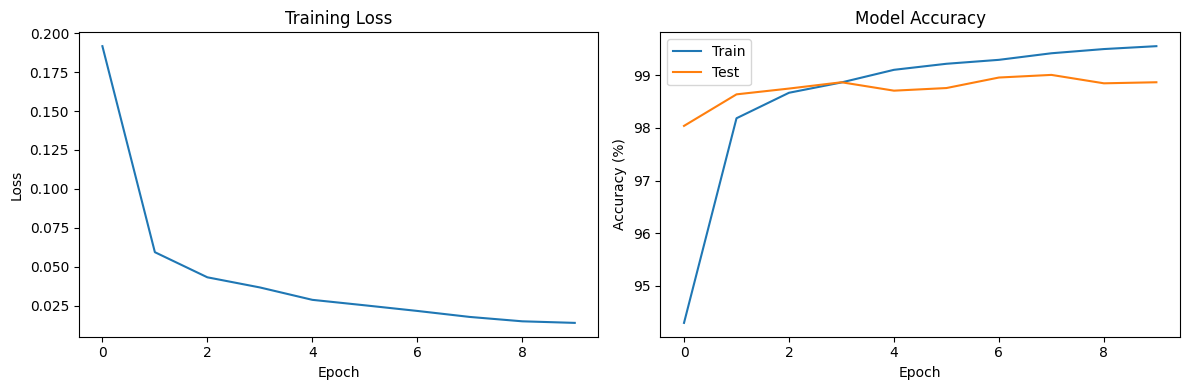


Final Test Accuracy: 98.87%


In [ ]:
# use model-1

if __name__ == '__main__':
    # Initialize hyperparameters
    params = HyperParameters()
    
    # Train the model
    model, train_losses, train_accuracies, test_accuracies = train_model(params)
    
    # Plot training metrics
    plot_metrics(train_losses, train_accuracies, test_accuracies)
    
    # Final evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False)
    
    final_test_accuracy = evaluate_model(model, test_loader, device)
    print(f'\nFinal Test Accuracy: {final_test_accuracy:.2f}%') 

### How does changing the batch size affects model

#### update Model Hyperparameters

In [ ]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 5
        self.batch_sizes = [16, 32, 64, 128, 256]
        # self.batch_size = 64
        self.learning_rate = 0.001
        self.dropout_rate = 0.25
        self.num_classes = 10
        self.momentum = 0.9
        self.random_seed = 42


In [10]:
def batch_size_analysis(params):
    results = {}
    
    for batch_size in params.batch_sizes:
        print(f"\nTesting batch size: {batch_size}")
        params.batch_size = batch_size
        
        # Train model with current batch size
        model, train_losses, train_accuracies, test_accuracies = train_model(params)
        
        # Store results
        results[batch_size] = {
            'final_train_acc': train_accuracies[-1],
            'final_test_acc': test_accuracies[-1],
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies
        }
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot training curves for different batch sizes
    plt.subplot(1, 2, 1)
    for batch_size in params.batch_sizes:
        plt.plot(results[batch_size]['train_accuracies'], 
                label=f'Batch {batch_size}')
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot final accuracies vs batch size
    plt.subplot(1, 2, 2)
    batch_sizes = list(results.keys())
    train_accs = [results[bs]['final_train_acc'] for bs in batch_sizes]
    test_accs = [results[bs]['final_test_acc'] for bs in batch_sizes]
    
    plt.plot(batch_sizes, train_accs, 'o-', label='Train')
    plt.plot(batch_sizes, test_accs, 'o-', label='Test')
    plt.title('Final Accuracy vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of results:")
    print("Batch Size | Train Acc | Test Acc")
    print("-" * 35)
    for batch_size in params.batch_sizes:
        print(f"{batch_size:^10d} | {results[batch_size]['final_train_acc']:^9.2f} | {results[batch_size]['final_test_acc']:^8.2f}")


Testing batch size: 16

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 32]          25,120
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330

Epoch 1/10: 100%|██████████| 3750/3750 [01:13<00:00, 51.11it/s, loss=0.291, acc=90.93%]


Epoch 1/10 - Loss: 0.2915, Train Acc: 90.93%, Test Acc: 97.62%


Epoch 2/10: 100%|██████████| 3750/3750 [01:11<00:00, 52.31it/s, loss=0.153, acc=95.31%]


Epoch 2/10 - Loss: 0.1535, Train Acc: 95.31%, Test Acc: 98.34%


Epoch 3/10: 100%|██████████| 3750/3750 [01:12<00:00, 51.84it/s, loss=0.124, acc=96.18%]


Epoch 3/10 - Loss: 0.1237, Train Acc: 96.18%, Test Acc: 98.46%


Epoch 4/10: 100%|██████████| 3750/3750 [01:13<00:00, 51.21it/s, loss=0.110, acc=96.60%]


Epoch 4/10 - Loss: 0.1102, Train Acc: 96.60%, Test Acc: 98.67%


Epoch 5/10: 100%|██████████| 3750/3750 [01:12<00:00, 51.85it/s, loss=0.100, acc=96.97%]


Epoch 5/10 - Loss: 0.0999, Train Acc: 96.97%, Test Acc: 98.57%


Epoch 6/10: 100%|██████████| 3750/3750 [01:11<00:00, 52.52it/s, loss=0.093, acc=97.24%]


Epoch 6/10 - Loss: 0.0926, Train Acc: 97.24%, Test Acc: 98.65%


Epoch 7/10: 100%|██████████| 3750/3750 [01:12<00:00, 51.95it/s, loss=0.086, acc=97.33%]


Epoch 7/10 - Loss: 0.0857, Train Acc: 97.33%, Test Acc: 98.77%


Epoch 8/10: 100%|██████████| 3750/3750 [01:10<00:00, 52.89it/s, loss=0.083, acc=97.48%]


Epoch 8/10 - Loss: 0.0826, Train Acc: 97.48%, Test Acc: 98.96%


Epoch 9/10: 100%|██████████| 3750/3750 [01:10<00:00, 52.98it/s, loss=0.078, acc=97.69%]


Epoch 9/10 - Loss: 0.0775, Train Acc: 97.69%, Test Acc: 98.80%


Epoch 10/10: 100%|██████████| 3750/3750 [01:10<00:00, 53.13it/s, loss=0.077, acc=97.59%]


Epoch 10/10 - Loss: 0.0771, Train Acc: 97.59%, Test Acc: 98.95%

Testing batch size: 32

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 32]          25,120
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0

Epoch 1/10: 100%|██████████| 1875/1875 [00:45<00:00, 40.84it/s, loss=0.355, acc=88.97%]


Epoch 1/10 - Loss: 0.3546, Train Acc: 88.97%, Test Acc: 97.32%


Epoch 2/10: 100%|██████████| 1875/1875 [00:45<00:00, 41.02it/s, loss=0.172, acc=94.70%]


Epoch 2/10 - Loss: 0.1720, Train Acc: 94.70%, Test Acc: 98.07%


Epoch 3/10: 100%|██████████| 1875/1875 [00:45<00:00, 41.03it/s, loss=0.142, acc=95.53%]


Epoch 3/10 - Loss: 0.1425, Train Acc: 95.53%, Test Acc: 98.34%


Epoch 4/10: 100%|██████████| 1875/1875 [26:19<00:00,  1.19it/s, loss=0.127, acc=96.12%]  


Epoch 4/10 - Loss: 0.1267, Train Acc: 96.12%, Test Acc: 98.57%


Epoch 5/10: 100%|██████████| 1875/1875 [00:47<00:00, 39.59it/s, loss=0.119, acc=96.29%]


Epoch 5/10 - Loss: 0.1190, Train Acc: 96.29%, Test Acc: 98.79%


Epoch 6/10: 100%|██████████| 1875/1875 [00:47<00:00, 39.68it/s, loss=0.108, acc=96.69%]


Epoch 6/10 - Loss: 0.1076, Train Acc: 96.69%, Test Acc: 98.68%


Epoch 7/10: 100%|██████████| 1875/1875 [00:47<00:00, 39.67it/s, loss=0.102, acc=96.85%]


Epoch 7/10 - Loss: 0.1018, Train Acc: 96.85%, Test Acc: 98.55%


Epoch 8/10: 100%|██████████| 1875/1875 [00:45<00:00, 41.65it/s, loss=0.099, acc=96.94%]


Epoch 8/10 - Loss: 0.0989, Train Acc: 96.94%, Test Acc: 98.71%


Epoch 9/10: 100%|██████████| 1875/1875 [00:47<00:00, 39.84it/s, loss=0.092, acc=97.09%]


Epoch 9/10 - Loss: 0.0921, Train Acc: 97.09%, Test Acc: 98.57%


Epoch 10/10: 100%|██████████| 1875/1875 [00:47<00:00, 39.89it/s, loss=0.091, acc=97.19%]


Epoch 10/10 - Loss: 0.0907, Train Acc: 97.19%, Test Acc: 98.90%

Testing batch size: 64

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 32]          25,120
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0

Epoch 1/10: 100%|██████████| 938/938 [00:36<00:00, 25.82it/s, loss=0.380, acc=88.44%]


Epoch 1/10 - Loss: 0.3802, Train Acc: 88.44%, Test Acc: 97.55%


Epoch 2/10: 100%|██████████| 938/938 [00:35<00:00, 26.40it/s, loss=0.169, acc=94.88%]


Epoch 2/10 - Loss: 0.1685, Train Acc: 94.88%, Test Acc: 98.01%


Epoch 3/10: 100%|██████████| 938/938 [00:35<00:00, 26.48it/s, loss=0.140, acc=95.67%]


Epoch 3/10 - Loss: 0.1399, Train Acc: 95.67%, Test Acc: 98.36%


Epoch 4/10: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s, loss=0.127, acc=96.08%]


Epoch 4/10 - Loss: 0.1275, Train Acc: 96.08%, Test Acc: 98.50%


Epoch 5/10: 100%|██████████| 938/938 [00:35<00:00, 26.38it/s, loss=0.115, acc=96.42%]


Epoch 5/10 - Loss: 0.1150, Train Acc: 96.42%, Test Acc: 98.43%


Epoch 6/10: 100%|██████████| 938/938 [00:35<00:00, 26.20it/s, loss=0.109, acc=96.65%]


Epoch 6/10 - Loss: 0.1092, Train Acc: 96.65%, Test Acc: 98.42%


Epoch 7/10: 100%|██████████| 938/938 [00:35<00:00, 26.23it/s, loss=0.103, acc=96.76%]


Epoch 7/10 - Loss: 0.1034, Train Acc: 96.76%, Test Acc: 98.67%


Epoch 8/10: 100%|██████████| 938/938 [00:35<00:00, 26.37it/s, loss=0.095, acc=97.03%]


Epoch 8/10 - Loss: 0.0952, Train Acc: 97.03%, Test Acc: 98.82%


Epoch 9/10: 100%|██████████| 938/938 [00:35<00:00, 26.27it/s, loss=0.093, acc=97.12%]


Epoch 9/10 - Loss: 0.0934, Train Acc: 97.12%, Test Acc: 98.65%


Epoch 10/10: 100%|██████████| 938/938 [00:36<00:00, 25.69it/s, loss=0.091, acc=97.15%]


Epoch 10/10 - Loss: 0.0911, Train Acc: 97.15%, Test Acc: 98.77%

Testing batch size: 128

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 32]          25,120
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               

Epoch 1/10: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s, loss=0.435, acc=86.84%]


Epoch 1/10 - Loss: 0.4346, Train Acc: 86.84%, Test Acc: 97.36%


Epoch 2/10: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s, loss=0.165, acc=94.95%]


Epoch 2/10 - Loss: 0.1654, Train Acc: 94.95%, Test Acc: 98.09%


Epoch 3/10: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s, loss=0.139, acc=95.72%]


Epoch 3/10 - Loss: 0.1388, Train Acc: 95.72%, Test Acc: 98.31%


Epoch 4/10: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s, loss=0.122, acc=96.28%]


Epoch 4/10 - Loss: 0.1224, Train Acc: 96.28%, Test Acc: 98.40%


Epoch 5/10: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s, loss=0.114, acc=96.49%]


Epoch 5/10 - Loss: 0.1144, Train Acc: 96.49%, Test Acc: 98.48%


Epoch 6/10: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s, loss=0.105, acc=96.80%]


Epoch 6/10 - Loss: 0.1053, Train Acc: 96.80%, Test Acc: 98.51%


Epoch 7/10: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s, loss=0.099, acc=96.92%]


Epoch 7/10 - Loss: 0.0987, Train Acc: 96.92%, Test Acc: 98.65%


Epoch 8/10: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s, loss=0.098, acc=96.99%]


Epoch 8/10 - Loss: 0.0975, Train Acc: 96.99%, Test Acc: 98.55%


Epoch 9/10: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s, loss=0.092, acc=97.16%]


Epoch 9/10 - Loss: 0.0917, Train Acc: 97.16%, Test Acc: 98.70%


Epoch 10/10: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s, loss=0.088, acc=97.24%]


Epoch 10/10 - Loss: 0.0878, Train Acc: 97.24%, Test Acc: 98.68%

Testing batch size: 256

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,168
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 32]          25,120
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               

Epoch 1/10: 100%|██████████| 235/235 [00:30<00:00,  7.73it/s, loss=0.576, acc=82.42%]


Epoch 1/10 - Loss: 0.5762, Train Acc: 82.42%, Test Acc: 96.75%


Epoch 2/10: 100%|██████████| 235/235 [00:30<00:00,  7.79it/s, loss=0.198, acc=93.98%]


Epoch 2/10 - Loss: 0.1981, Train Acc: 93.98%, Test Acc: 97.71%


Epoch 3/10: 100%|██████████| 235/235 [00:30<00:00,  7.76it/s, loss=0.154, acc=95.42%]


Epoch 3/10 - Loss: 0.1543, Train Acc: 95.42%, Test Acc: 98.20%


Epoch 4/10: 100%|██████████| 235/235 [00:29<00:00,  7.84it/s, loss=0.135, acc=95.90%]


Epoch 4/10 - Loss: 0.1349, Train Acc: 95.90%, Test Acc: 98.27%


Epoch 5/10: 100%|██████████| 235/235 [00:30<00:00,  7.78it/s, loss=0.121, acc=96.32%]


Epoch 5/10 - Loss: 0.1214, Train Acc: 96.32%, Test Acc: 98.41%


Epoch 6/10: 100%|██████████| 235/235 [00:30<00:00,  7.80it/s, loss=0.112, acc=96.61%]


Epoch 6/10 - Loss: 0.1123, Train Acc: 96.61%, Test Acc: 98.54%


Epoch 7/10: 100%|██████████| 235/235 [00:28<00:00,  8.18it/s, loss=0.107, acc=96.69%]


Epoch 7/10 - Loss: 0.1071, Train Acc: 96.69%, Test Acc: 98.58%


Epoch 8/10: 100%|██████████| 235/235 [00:29<00:00,  7.88it/s, loss=0.100, acc=97.01%]


Epoch 8/10 - Loss: 0.1002, Train Acc: 97.01%, Test Acc: 98.69%


Epoch 9/10: 100%|██████████| 235/235 [00:29<00:00,  7.91it/s, loss=0.097, acc=96.89%]


Epoch 9/10 - Loss: 0.0975, Train Acc: 96.89%, Test Acc: 98.52%


Epoch 10/10: 100%|██████████| 235/235 [00:29<00:00,  7.84it/s, loss=0.092, acc=97.15%]


Epoch 10/10 - Loss: 0.0924, Train Acc: 97.15%, Test Acc: 98.69%


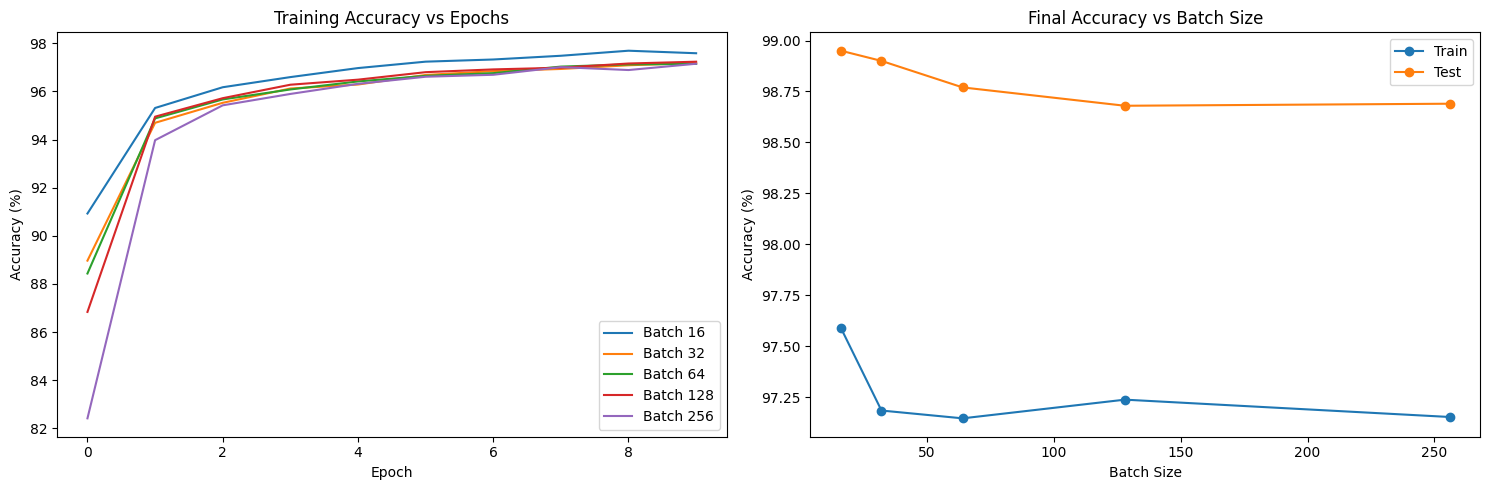


Summary of results:
Batch Size | Train Acc | Test Acc
-----------------------------------
    16     |   97.59   |  98.95  
    32     |   97.19   |  98.90  
    64     |   97.15   |  98.77  
   128     |   97.24   |  98.68  
   256     |   97.15   |  98.69  


In [12]:
# use model-2

if __name__ == '__main__':
    params = HyperParameters()
    batch_size_analysis(params) 

---

## use updated model architecture 

In [13]:
class TinyCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(TinyCNN, self).__init__()
        
        # First Convolutional Block - No BatchNorm or MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),  # RF: 3x3
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),  # RF: 5x5
            nn.ReLU()
        )
        
        # Second Convolutional Block - Add BatchNorm and MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1),  # RF: 7x7
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 16, kernel_size=3, padding=1),  # RF: 9x9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # RF: 10x10, Size: 14x14
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 20, kernel_size=3, padding=1),  # RF: 14x14
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(20, 16, kernel_size=3, padding=1),  # RF: 18x18
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # RF: 20x20, Size: 7x7
        )
        
        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),  # RF: 28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(16, 16, kernel_size=1),  # RF: 28x28 (1x1 conv)
            nn.ReLU()
        )
        
        # Single Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(16 * 7 * 7, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def train_model(params):
    # Set random seed for reproducibility
    torch.manual_seed(params.random_seed)
    
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TinyCNN(params.dropout_rate).to(device)
    
    # Print model summary
    print("\nModel Summary:")
    summary(model, input_size=(1, 28, 28))
    print("\nStarting Training...\n")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Track best model
    best_test_accuracy = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Training loop
    for epoch in range(params.num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{params.num_epochs}')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{running_loss/len(progress_bar):.3f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)
        
        # Save best model
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
            print(f'New best model saved at epoch {epoch+1} with test accuracy: {test_accuracy:.2f}%')    
            # print(f'New best model saved with test accuracy: {test_accuracy:.2f}%')
        
        # Modified metrics printing
        print(f'Epoch {epoch+1}/{params.num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
    
    # Load best model before returning
    model.load_state_dict(best_model_state)
    print(f'\nLoaded best model with test accuracy: {best_test_accuracy:.2f}%')
    
    # Save the best model to disk (modified)
    torch.save(
        best_model_state,  # Save only the model state dict
        'best_mnist_model.pth'
    )
    
    return model, train_losses, train_accuracies, test_accuracies

In [15]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

In [16]:
def load_and_evaluate_model(model_path, params):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model
    model = TinyCNN(params.dropout_rate).to(device)
    
    # Load saved model (modified)
    model_state = torch.load(model_path)
    model.load_state_dict(model_state)
    print(f"Loaded model weights from {model_path}")
    
    # Prepare test data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False)
    
    # Evaluate
    test_accuracy = evaluate_model(model, test_loader, device)
    print(f'Current test accuracy: {test_accuracy:.2f}%')
    
    return model, test_accuracy

In [17]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 20
        self.batch_size = 512
        self.learning_rate = 0.0005
        self.dropout_rate = 0.25
        self.num_classes = 10
        self.momentum = 0.9
        self.random_seed = 42

In [18]:
params = HyperParameters()
    
# Train the model
model, train_losses, train_accuracies, test_accuracies = train_model(params)


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
            Conv2d-8           [-1, 16, 28, 28]           1,744
       BatchNorm2d-9           [-1, 16, 28, 28]              32
             ReLU-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 20, 14, 14]           2,900
      BatchNorm2d-13           [-1, 20, 14, 14]              40
             ReLU-14   

Epoch 1/20: 100%|██████████| 118/118 [00:13<00:00,  8.70it/s, loss=1.062, acc=75.07%]


Epoch 1/20 - Loss: 1.0616, Train Acc: 75.07%, Test Acc: 95.01%


Epoch 2/20: 100%|██████████| 118/118 [00:14<00:00,  8.22it/s, loss=0.196, acc=94.79%]


Epoch 2/20 - Loss: 0.1962, Train Acc: 94.79%, Test Acc: 97.33%


Epoch 3/20: 100%|██████████| 118/118 [00:14<00:00,  8.41it/s, loss=0.121, acc=96.53%]


Epoch 3/20 - Loss: 0.1215, Train Acc: 96.53%, Test Acc: 98.10%


Epoch 4/20: 100%|██████████| 118/118 [00:13<00:00,  8.43it/s, loss=0.093, acc=97.22%]


Epoch 4/20 - Loss: 0.0932, Train Acc: 97.22%, Test Acc: 98.46%


Epoch 5/20: 100%|██████████| 118/118 [00:13<00:00,  8.64it/s, loss=0.080, acc=97.66%]


Epoch 5/20 - Loss: 0.0796, Train Acc: 97.66%, Test Acc: 98.57%


Epoch 6/20: 100%|██████████| 118/118 [00:13<00:00,  8.69it/s, loss=0.070, acc=97.89%]


Epoch 6/20 - Loss: 0.0703, Train Acc: 97.89%, Test Acc: 98.72%


Epoch 7/20: 100%|██████████| 118/118 [00:13<00:00,  8.69it/s, loss=0.064, acc=98.09%]


Epoch 7/20 - Loss: 0.0639, Train Acc: 98.09%, Test Acc: 98.75%


Epoch 8/20: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s, loss=0.058, acc=98.22%]


Epoch 8/20 - Loss: 0.0583, Train Acc: 98.22%, Test Acc: 98.75%


Epoch 9/20: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s, loss=0.057, acc=98.26%]


Epoch 9/20 - Loss: 0.0566, Train Acc: 98.26%, Test Acc: 98.82%


Epoch 10/20: 100%|██████████| 118/118 [00:13<00:00,  8.63it/s, loss=0.052, acc=98.47%]


Epoch 10/20 - Loss: 0.0520, Train Acc: 98.47%, Test Acc: 98.95%


Epoch 11/20: 100%|██████████| 118/118 [00:13<00:00,  8.66it/s, loss=0.049, acc=98.52%]


Epoch 11/20 - Loss: 0.0489, Train Acc: 98.52%, Test Acc: 98.86%


Epoch 12/20: 100%|██████████| 118/118 [00:13<00:00,  8.54it/s, loss=0.046, acc=98.59%]


Epoch 12/20 - Loss: 0.0463, Train Acc: 98.59%, Test Acc: 98.99%


Epoch 13/20: 100%|██████████| 118/118 [00:14<00:00,  8.38it/s, loss=0.043, acc=98.65%]


Epoch 13/20 - Loss: 0.0430, Train Acc: 98.65%, Test Acc: 99.10%


Epoch 14/20: 100%|██████████| 118/118 [00:14<00:00,  8.36it/s, loss=0.041, acc=98.73%]


Epoch 14/20 - Loss: 0.0412, Train Acc: 98.73%, Test Acc: 99.13%


Epoch 15/20: 100%|██████████| 118/118 [00:14<00:00,  8.22it/s, loss=0.040, acc=98.78%]


Epoch 15/20 - Loss: 0.0402, Train Acc: 98.78%, Test Acc: 99.12%


Epoch 16/20: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s, loss=0.041, acc=98.68%]


Epoch 16/20 - Loss: 0.0413, Train Acc: 98.68%, Test Acc: 99.10%


Epoch 17/20: 100%|██████████| 118/118 [00:14<00:00,  8.11it/s, loss=0.038, acc=98.75%]


Epoch 17/20 - Loss: 0.0380, Train Acc: 98.75%, Test Acc: 99.14%


Epoch 18/20: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s, loss=0.037, acc=98.83%]


Epoch 18/20 - Loss: 0.0367, Train Acc: 98.83%, Test Acc: 99.06%


Epoch 19/20: 100%|██████████| 118/118 [00:14<00:00,  8.12it/s, loss=0.035, acc=98.91%]


Epoch 19/20 - Loss: 0.0351, Train Acc: 98.91%, Test Acc: 99.18%


Epoch 20/20: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s, loss=0.035, acc=98.88%]


Epoch 20/20 - Loss: 0.0352, Train Acc: 98.88%, Test Acc: 99.17%

Loaded best model with test accuracy: 99.18%


In [19]:
evaluate_model(model, test_loader, device)

99.17

###